In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import timm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

In [3]:
class Config:
    FUNDUS_BACKBORNE='efficientnet_b0' # 'resnet18' 'convnext_tiny' efficientnet_b
    FUNDUS_BACKBORNE='efficientnet_b0' # 'resnet18' efficientnet_b
    OCT_BACKBORNE='efficientnet_b0'

    DATA = '/content/drive/MyDrive/Computer Vision/DR DME/DR_Fundus_and_OCT_paired_data.csv'
    IMG_DIR = '/content/drive/MyDrive/Computer Vision/DR DME/paired_fundus_and_OCT_DR_dataset'

    BATCH_SIZE = 8
    LR=1e-4
    PATIENCE = 2
    EPOCHS = 5

    SAVE_MODEL = f'/content/drive/MyDrive/Computer Vision/DR DME/{FUNDUS_BACKBORNE}_{EPOCHS}.pth'

In [ ]:
img_dir = Config.IMG_DIR
data = Config.DATA
df = pd.read_csv(data)
df

,Name,Name.1,DME,DR
0,1221_LeftEye_fundus,1221_LeftEye_oct,0,0
1,1222_LeftEye_fundus,1222_LeftEye_oct,0,0
2,1222_RightEye_fundus,1222_RightEye_oct,0,0
3,1223_LeftEye_fundus,1223_LeftEye_oct,0,0
4,1223_RightEye_fundus,1223_RightEye_oct,0,0
...,...,...,...,...
419,2055_LeftEye_fundus,2055_LeftEye_oct,0,0
420,2055_RightEye_fundus,2055_RightEye_oct,0,0
421,2056_LeftEye_fundus,2056_LeftEye_oct,0,0
422,2056_RightEye_fundus,2056_RightEye_oct,0,0


In [ ]:
df['DME'].value_counts(dropna=True) # 'No DME', 'DME'

,count
DME,
0,377
1,47


In [ ]:
df['DR'].value_counts(dropna=True)  # 'No DR', 'NPDR', 'PDR'

,count
DR,
0,289
1,84
2,51


In [ ]:
train_ids, test_ids = train_test_split(
    df['Name'].unique(),
    test_size=0.2,
    random_state=42
)
train_ids, val_ids = train_test_split(
    train_ids,
    test_size=0.2,
    random_state=42
)
train_df = df[df.Name.isin(train_ids)]
val_df = df[df.Name.isin(val_ids)]
test_df = df[df.Name.isin(test_ids)]

In [ ]:
class FundusOctDataset(Dataset):
    def __init__(self, data, img_dir, fundus_tfms, oct_tfms):
        self.df = data.reset_index(drop=True)
        self.img_dir = img_dir
        self.fundus_tfms = fundus_tfms
        self.oct_tfms = oct_tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fundus_path = os.path.join(self.img_dir, row['Name'] + '.jpg')
        oct_path = os.path.join(self.img_dir, row['Name.1'] + '.jpg')

        fundus_img = Image.open(fundus_path).convert('RGB')
        oct_img = Image.open(oct_path).convert('RGB')

        fundus_img = self.fundus_tfms(fundus_img)
        oct_img = self.oct_tfms(oct_img)

        dr_label = row['DR']
        dme_label = row['DME']

        return fundus_img, oct_img, torch.tensor(dr_label), torch.tensor(dme_label)

In [ ]:
# train transforms
fundus_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229,  0.224, 0.225]
    )
])

oct_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5],
        std=[0.5]
    )
])

In [ ]:
# validation transforms
val_fundus_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229,  0.224, 0.225]
    )
])

val_oct_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5],
        std=[0.5]
    )
])

In [ ]:
datasets = {
    'train_ds': FundusOctDataset(
        data=train_df,
        img_dir=img_dir,
        fundus_tfms=fundus_transform,
        oct_tfms=oct_transform
    ),
    'val_ds': FundusOctDataset(
        data=val_df,
        img_dir=img_dir,
        fundus_tfms=val_fundus_transform,
        oct_tfms=val_oct_transform
    ),
    'test_ds': FundusOctDataset(
        data=test_df,
        img_dir=img_dir,
        fundus_tfms=val_fundus_transform,
        oct_tfms=val_oct_transform
    ),
}

In [ ]:
loaders = {
    'train_loader': DataLoader(
        dataset=datasets['train_ds'],
        batch_size=Config.BATCH_SIZE,
        shuffle=True
    ),
    'val_loader': DataLoader(
        dataset=datasets['val_ds'],
        batch_size=Config.BATCH_SIZE,
        shuffle=True
    ),
    'test_loader': DataLoader(
        dataset=datasets['test_ds'],
        batch_size=Config.BATCH_SIZE,
        shuffle=True
    )
}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# compute class weights for balance
dr_classes = np.array([0, 1, 2])
dr_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=dr_classes,
    y=train_df['DR'].values
)
dr_class_weight = torch.tensor(dr_class_weights, dtype=torch.float).to(device)


In [ ]:
dme_classes = np.array([0, 1])
dme_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=dme_classes,
    y=train_df['DME'].values
)
dme_class_weight = torch.tensor(dme_class_weights, dtype=torch.float).to(device)

In [ ]:
class FusionModel(nn.Module):
    def __init__(self, fundus_backbone='efficientnet_b0', oct_backbone='efficientnet_b0'):
        super(FusionModel, self).__init__()

        self.fundus_net = timm.create_model(fundus_backbone, pretrained=True, num_classes=0)
        self.oct_net = timm.create_model(oct_backbone, pretrained=True, num_classes=0)

        fundus_dim = self.fundus_net.num_features
        oct_dim = self.oct_net.num_features
        fusion_input_dim = fundus_dim + oct_dim

        self.fundus_net.classifier = nn.Identity()
        self.oct_net.classifier = nn.Identity()

        self.shared_fc = nn.Sequential(
            nn.Linear(fusion_input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.dr_head = nn.Linear(512, 3)
        self.dme_head = nn.Linear(512, 1)


    def forward(self, fundus, oct):
        f1 = self.fundus_net(fundus)
        f2 = self.oct_net(oct)

        fused = torch.cat([f1, f2], dim=1)
        features = self.shared_fc(fused)

        dr_logist = self.dr_head(features)
        dme_logist = self.dme_head(features)

        return dr_logist, dme_logist

In [ ]:
model = FusionModel(
    fundus_backbone=Config.FUNDUS_BACKBORNE,
    oct_backbone=Config.OCT_BACKBORNE
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=Config.LR)
criterion_dr = nn.CrossEntropyLoss(weight=dr_class_weight)
criterion_dme = nn.BCEWithLogitsLoss(pos_weight=dme_class_weight[1])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=2)
scaler = torch.amp.GradScaler(enabled=(device.type != 'cpu'))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report

In [ ]:
def train_one_epoch(model, loader, optimizer, device, scaler, criterion_dr, criterion_dme, epoch):
    model.train()

    total_loss = 0

    dr_probs_all, dr_labels_all = [], []
    dme_probs_all, dme_labels_all = [], []

    for fundus, oct, dr, dme in tqdm(loader, desc=f'Ep {epoch}'):
        fundus = fundus.to(device)
        oct = oct.to(device)
        dr = dr.to(device)
        dme = dme.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        dr_logist, dme_logist = model(fundus, oct)

        loss_dr = criterion_dr(dr_logist, dr)
        loss_dme = criterion_dme(dme_logist, dme)
        loss = loss_dr + loss_dme

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        dr_probs = torch.softmax(dr_logist, dim=1)
        dme_probs = torch.sigmoid(dme_logist)

        dr_probs_all.append(dr_probs.detach().cpu())
        dr_labels_all.append(dr.detach().cpu())

        dme_probs_all.append(dme_probs.detach().cpu())
        dme_labels_all.append(dme.detach().cpu())

    dr_probs_all = torch.cat(dr_probs_all).numpy()
    dr_labels_all = torch.cat(dr_labels_all).numpy()

    dme_probs_all = torch.cat(dme_probs_all).numpy()
    dme_labels_all = torch.cat(dme_labels_all).squeeze().numpy()

    # DR metrics
    dr_preds = np.argmax(dr_probs_all, axis=1)
    dr_metrics = {
        'acc': accuracy_score(dr_labels_all, dr_preds),
        'prec': precision_score(dr_labels_all, dr_preds, average='macro'),
        'rec': recall_score(dr_labels_all, dr_preds, average='macro'),
        'auc': roc_auc_score(dr_labels_all, dr_probs_all, multi_class='ovr')
    }

    # DME metrics
    dme_preds = (dme_probs_all > 0.5).astype(int)
    dme_metrics = {
        'acc': accuracy_score(dme_labels_all, dme_preds),
        'prec': precision_score(dme_labels_all, dme_preds, average='macro'),
        'rec': recall_score(dme_labels_all, dme_preds, average='macro'),
        'auc': roc_auc_score(dme_labels_all, dme_probs_all, multi_class='ovr')
    }

    avg_loss = total_loss / len(loader)

    return avg_loss, dr_metrics, dme_metrics

In [ ]:
def evaluate(model, loader, device, criterion_dr, criterion_dme, epoch):
    model.eval()

    total_loss = 0

    dr_probs_all, dr_labels_all = [], []
    dme_probs_all, dme_labels_all = [], []

    for fundus, oct, dr, dme in tqdm(loader, desc=f'Val Ep {epoch}'):
        fundus = fundus.to(device)
        oct = oct.to(device)
        dr = dr.to(device)
        dme = dme.float().to(device).unsqueeze(1)

        dr_logist, dme_logist = model(fundus, oct)

        loss_dr = criterion_dr(dr_logist, dr)
        loss_dme = criterion_dme(dme_logist, dme)
        loss = loss_dr + loss_dme
        total_loss += loss.item()

        dr_probs = torch.softmax(dr_logist, dim=1)
        dme_probs = torch.sigmoid(dme_logist)

        dr_probs_all.append(dr_probs.detach().cpu())
        dr_labels_all.append(dr.detach().cpu())

        dme_probs_all.append(dme_probs.detach().cpu())
        dme_labels_all.append(dme.detach().cpu())

    dr_probs_all = torch.cat(dr_probs_all).numpy()
    dr_labels_all = torch.cat(dr_labels_all).numpy()

    dme_probs_all = torch.cat(dme_probs_all).numpy()
    dme_labels_all = torch.cat(dme_labels_all).numpy().flatten()

    # DR metrics
    dr_preds = np.argmax(dr_probs_all, axis=1)
    dr_metrics = {
        'acc': accuracy_score(dr_labels_all, dr_preds),
        'prec': precision_score(dr_labels_all, dr_preds, average='macro', zero_division=0),
        'rec': recall_score(dr_labels_all, dr_preds, average='macro', zero_division=0),
        'auc': roc_auc_score(dr_labels_all, dr_probs_all, multi_class='ovr')
    }

    # DME metrics
    dme_preds = (dme_probs_all > 0.5).astype(int)
    dme_metrics = {
        'acc': accuracy_score(dme_labels_all, dme_preds),
        'prec': precision_score(dme_labels_all, dme_preds, average='macro'),
        'rec': recall_score(dme_labels_all, dme_preds, average='macro'),
        'auc': roc_auc_score(dme_labels_all, dme_probs_all, multi_class='ovr')
    }

    avg_loss = total_loss / len(loader)

    return avg_loss, dr_metrics, dme_metrics

In [ ]:
def run_full_train(model, train_loader, val_loader, optimizer, scheduler, patience, criterion_dr, criterion_dme, scaler, device, epochs, save_path):
    best_loss = float('inf')
    patience_counter = 0

    history = {
        'train_loss': [], 'val_loss': [],
        'dr_train_acc': [], 'dr_val_acc': [],
        'dr_train_prec': [], 'dr_val_prec': [],
        'dr_train_rec': [], 'dr_val_rec': [],
        'dr_train_auc': [], 'dr_val_auc': [],
        'dme_train_acc': [], 'dme_val_acc': [],
        'dme_train_prec': [], 'dme_val_prec': [],
        'dme_train_rec': [], 'dme_val_rec': [],
        'dme_train_auc': [], 'dme_val_auc': []
    }

    for epoch in range(1, epochs + 1 ):
        t_loss, t_dr, t_dme = train_one_epoch(model, train_loader, optimizer, device, scaler, criterion_dr, criterion_dme, epoch)
        v_loss, v_dr, v_dme = evaluate(model, val_loader, device, criterion_dr, criterion_dme, epoch)
        # loss
        history['train_loss'].append(t_loss)
        history['val_loss'].append(v_loss)
        # accuracy
        history['dr_train_acc'].append(t_dr['acc'])
        history['dr_val_acc'].append(v_dr['acc'])
        history['dme_train_acc'].append(t_dme['acc'])
        history['dme_val_acc'].append(v_dme['acc'])
        # precision
        history['dr_train_prec'].append(t_dr['prec'])
        history['dr_val_prec'].append(v_dr['prec'])
        history['dme_train_prec'].append(t_dme['prec'])
        history['dme_val_prec'].append(v_dme['prec'])
        # recall
        history['dr_train_rec'].append(t_dr['rec'])
        history['dr_val_rec'].append(v_dr['rec'])
        history['dme_train_rec'].append(t_dme['rec'])
        history['dme_val_rec'].append(v_dme['rec'])
        # auc
        history['dr_train_auc'].append(t_dr['auc'])
        history['dr_val_auc'].append(v_dr['auc'])
        history['dme_train_auc'].append(t_dme['auc'])
        history['dme_val_auc'].append(v_dme['auc'])

        print(f'Epoch [{epoch}/{epochs}]')
        print(f'Train loss: {t_loss:.4f} | dr_train_rec: {t_dr['rec']:.4f} | dme_train_rec: {t_dme['rec']:.4f}')
        print(f'Val loss: {v_loss:.4f} | dr_val_rec: {v_dr['rec']:.4f} | dme_val_rec: {v_dme['rec']:.4f}')

        scheduler.step(v_loss)
        if v_loss < best_loss:
            best_loss = v_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            print('No improvement')
        if patience_counter > patience:
            print('Early stopping triggered')
            break

    return history


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_result(history):
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axes = plt.subplots(4, 2, figsize=(15, 18))

    # loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    axes[0, 0].plot(epochs, history['val_loss'], 'r--', label='Val Loss')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Eppochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # auc
    axes[0, 1].plot(epochs, history['dr_val_auc'], 'b-', label='DE AUC')
    axes[0, 1].plot(epochs, history['dme_val_auc'], 'r--', label='DME AUC')
    axes[0, 1].set_title('ROC-AUC')
    axes[0, 1].set_xlabel('Eppochs')
    axes[0, 1].set_ylabel('auc')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # acc DR
    axes[1, 0].plot(epochs, history['dr_train_acc'], 'b-', label='Train DE Accuracy')
    axes[1, 0].plot(epochs, history['dr_val_acc'], 'r--', label='Val DR Accuracy')
    axes[1, 0].set_title('DR Accuracy')
    axes[1, 0].set_xlabel('Eppochs')
    axes[1, 0].set_ylabel('acc')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    # acc DME
    axes[1, 1].plot(epochs, history['dme_train_acc'], 'b-', label='Train DME Accuracy')
    axes[1, 1].plot(epochs, history['dme_val_acc'], 'r--', label='Val DME Accuracy')
    axes[1, 1].set_title('DME Accuracy')
    axes[1, 1].set_xlabel('Eppochs')
    axes[1, 1].set_ylabel('acc')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    # prec DR
    axes[2, 0].plot(epochs, history['dr_train_prec'], 'b-', label='Train DE Precision')
    axes[2, 0].plot(epochs, history['dr_val_acc'], 'r--', label='Val DR Precision')
    axes[2, 0].set_title('DR Precision')
    axes[2, 0].set_xlabel('Eppochs')
    axes[2, 0].set_ylabel('prec')
    axes[2, 0].legend()
    axes[2, 0].grid(True)
    # prec DME
    axes[2, 1].plot(epochs, history['dme_train_prec'], 'b-', label='Train DME Precision')
    axes[2, 1].plot(epochs, history['dme_val_prec'], 'r--', label='Val DME Precision')
    axes[2, 1].set_title('DME Precisiom')
    axes[2, 1].set_xlabel('Eppochs')
    axes[2, 1].set_ylabel('prec')
    axes[2, 1].legend()
    axes[2, 1].grid(True)

    # prec DR
    axes[3, 0].plot(epochs, history['dr_train_rec'], 'b-', label='Train DE Recall')
    axes[3, 0].plot(epochs, history['dr_val_rec'], 'r--', label='Val DR Recall')
    axes[3, 0].set_title('DR Recall')
    axes[3, 0].set_xlabel('Eppochs')
    axes[3, 0].set_ylabel('rec')
    axes[3, 0].legend()
    axes[3, 0].grid(True)
    # prec DME
    axes[3, 1].plot(epochs, history['dme_train_rec'], 'b-', label='Train DME Recall')
    axes[3, 1].plot(epochs, history['dme_val_rec'], 'r--', label='Val DME Recall')
    axes[3, 1].set_title('DME Recall')
    axes[3, 1].set_xlabel('Eppochs')
    axes[3, 1].set_ylabel('rec')
    axes[3, 1].legend()
    axes[3, 1].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns

In [ ]:
def test_model(model, test_loader, device, model_path):
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.eval()

    dr_probs_all, dr_labels_all = [], []
    dme_probs_all, dme_labels_all = [], []

    with torch.no_grad():
        for fundus, oct, dr, dme in tqdm(test_loader, desc='Testing'):
            fundus, oct = fundus.to(device), oct.to(device)
            dr = dr.to(device)
            dme = dme.float().to(device).unsqueeze(1)

            dr_logist, dme_logist = model(fundus, oct)

            dr_probs = torch.softmax(dr_logist, dim=1).cpu()
            dr_probs_all.append(dr_probs)
            dr_labels_all.append(dr.cpu())  # Corrected from dme.cpu()

            dme_probs = torch.sigmoid(dme_logist).cpu()
            dme_probs_all.append(dme_probs)
            dme_labels_all.append(dme.cpu())

    dr_probs_all = torch.cat(dr_probs_all).numpy()
    dr_labels_all = torch.cat(dr_labels_all).numpy()
    dr_preds = np.argmax(dr_probs_all, axis=1)

    dme_probs_all = torch.cat(dme_probs_all).numpy()
    dme_labels_all = torch.cat(dme_labels_all).numpy()
    dme_preds = (dme_probs_all > 0.5).astype(int)

    print('=== DR ===')
    print(classification_report(dr_labels_all, dr_preds, target_names=['No DR', 'NPDR', 'PDR']))
    dr_auc = roc_auc_score(dr_labels_all, dr_probs_all, multi_class='ovr')
    print(f'DR_AUC: {dr_auc:.4f}')

    print('=== DME ===')
    print(classification_report(dme_labels_all, dme_preds, target_names=['No DME', 'DME']))
    dme_auc = roc_auc_score(dme_labels_all, dme_probs_all)
    print(f'DR_AUC: {dme_auc:.4f}')

    fig, axes = plt.subplots(1, 2, figsize=(12, 10))
    # confusion matrix
    # DR
    cm_dr = confusion_matrix(dr_labels_all, dr_preds)
    sns.heatmap(cm_dr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['No DR', 'NPDR', 'PDR'], yticklabels=['No DR', 'NPDR', 'PDR'])
    axes[0].set_title('DR confusion matrix')
    axes[0].set_xlabel('Prediction')
    axes[0].set_ylabel('True')
    # DME
    cm_dme = confusion_matrix(dme_labels_all, dme_preds)
    sns.heatmap(cm_dme, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=['No DME', 'DME'], yticklabels=['No DME', 'DME'])
    axes[0].set_title('DME confusion matrix')
    axes[0].set_xlabel('Prediction')
    axes[0].set_ylabel('True')

    plt.tight_layout()
    plt.show()

In [ ]:
# RUN
train_val_history = run_full_train(
    model=model,
    train_loader=loaders['train_loader'],
    val_loader=loaders['val_loader'],
    scheduler=scheduler,
    patience=Config.PATIENCE,
    criterion_dr=criterion_dr,
    criterion_dme=criterion_dme,
    scaler=scaler,
    device=device,
    epochs=Config.EPOCHS,
    save_path=Config.SAVE_MODEL,
    optimizer=optimizer
)

Val Ep 1: 100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [1/5]
Train loss: 1.6804 | dr_train_rec: 0.5387 | dme_train_rec: 0.7256
Val loss: 1.2546 | dr_val_rec: 0.6184 | dme_val_rec: 0.9286


Val Ep 2: 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]


Epoch [2/5]
Train loss: 1.1432 | dr_train_rec: 0.7106 | dme_train_rec: 0.9025
Val loss: 1.1786 | dr_val_rec: 0.6903 | dme_val_rec: 0.9524


Val Ep 3: 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]


Epoch [3/5]
Train loss: 0.8784 | dr_train_rec: 0.8393 | dme_train_rec: 0.8982
Val loss: 0.9343 | dr_val_rec: 0.7507 | dme_val_rec: 0.9683


Val Ep 4: 100%|██████████| 9/9 [00:02<00:00,  4.08it/s]


Epoch [4/5]
Train loss: 0.7037 | dr_train_rec: 0.8513 | dme_train_rec: 0.9501
Val loss: 0.8054 | dr_val_rec: 0.7699 | dme_val_rec: 0.9683


Val Ep 5: 100%|██████████| 9/9 [00:02<00:00,  3.21it/s]

Epoch [5/5]
Train loss: 0.6365 | dr_train_rec: 0.8800 | dme_train_rec: 0.9522
Val loss: 0.8259 | dr_val_rec: 0.8006 | dme_val_rec: 0.9603
No improvement


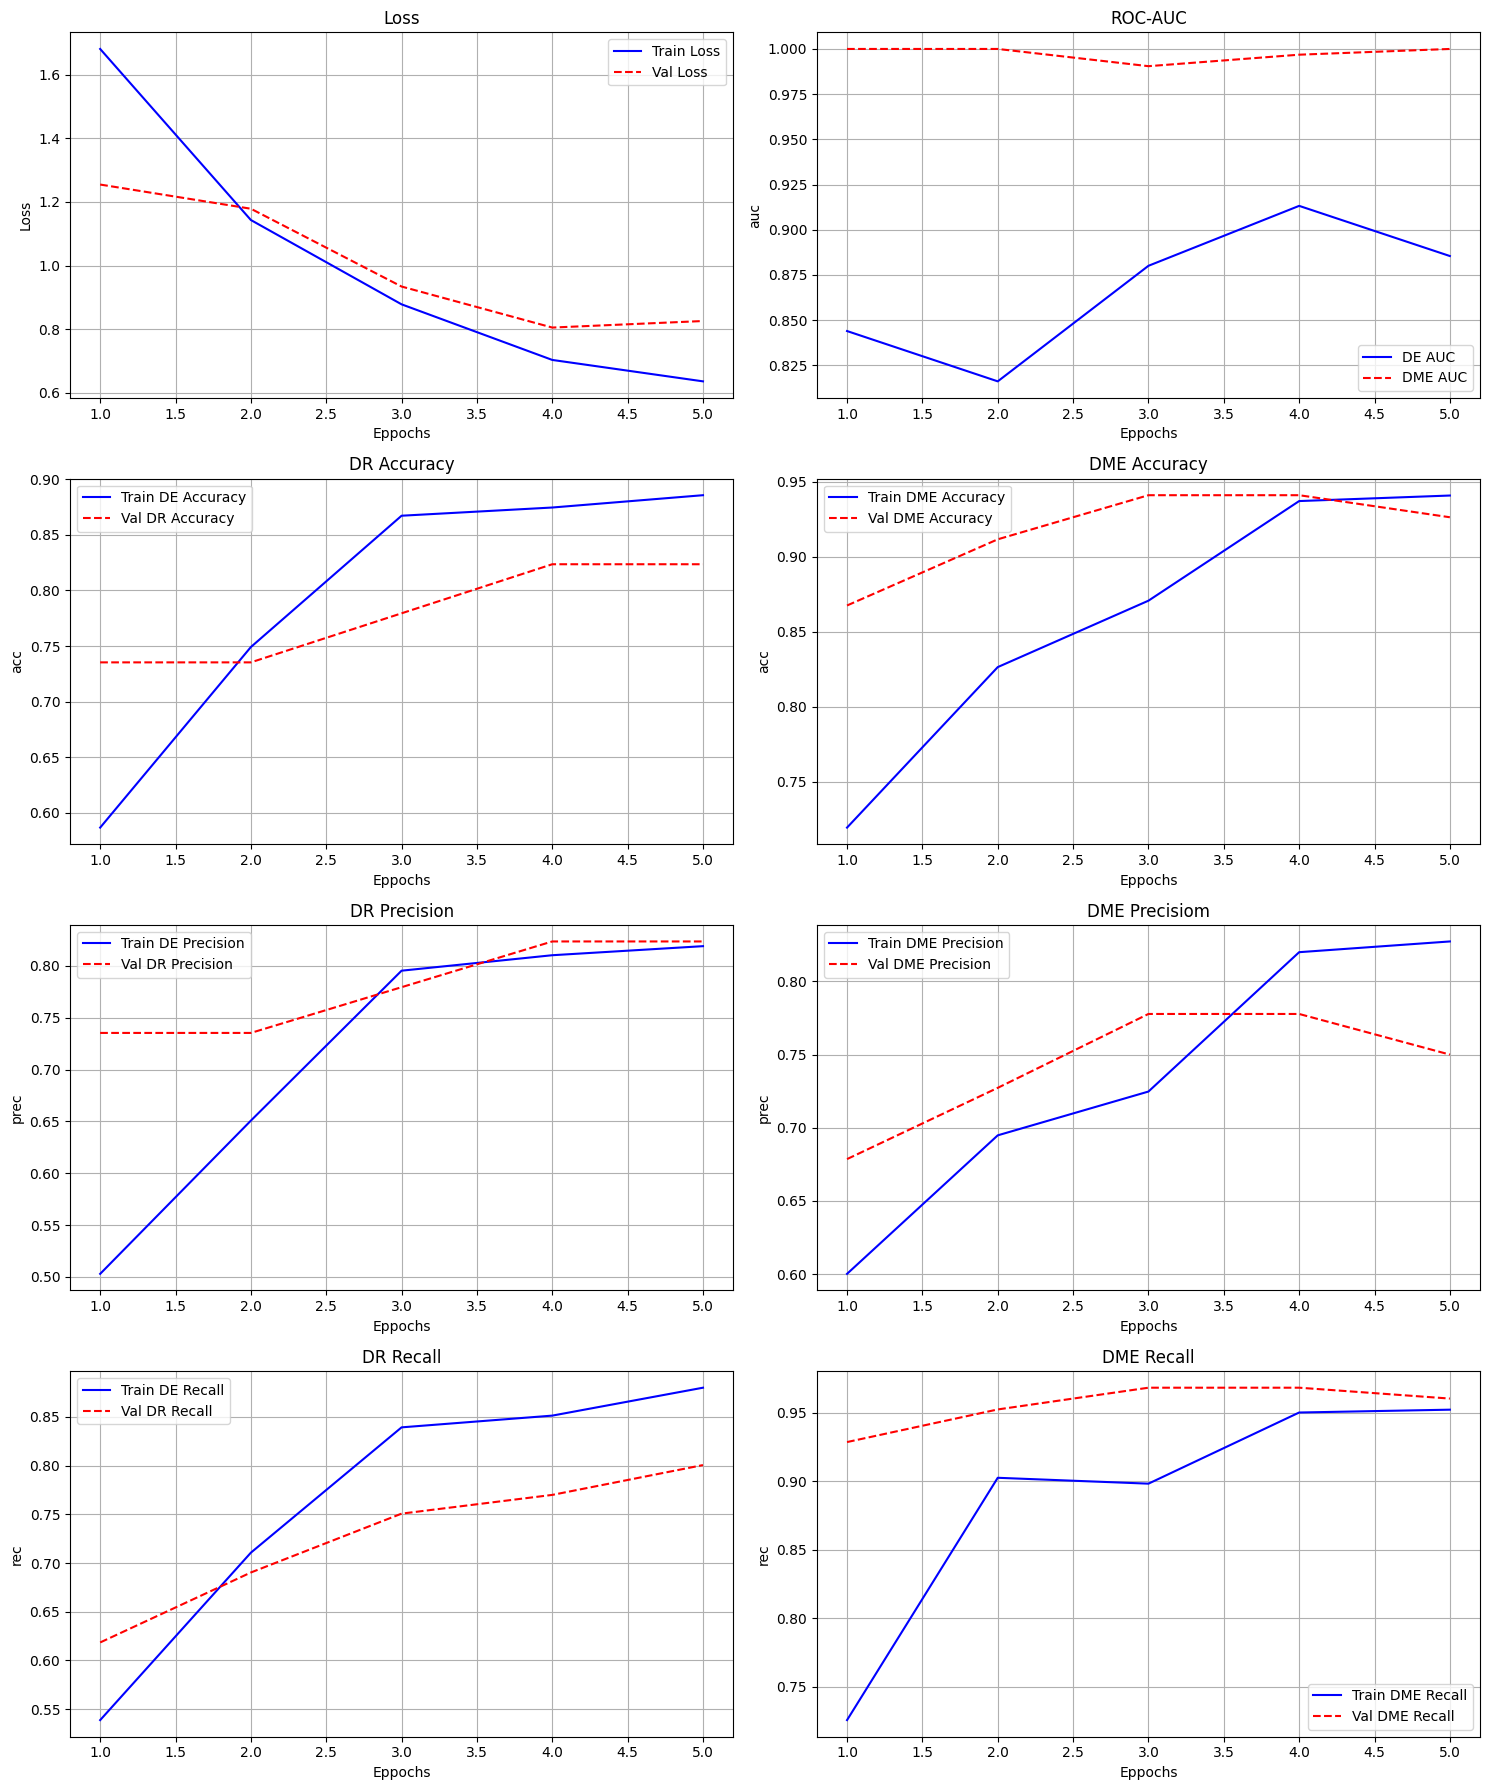

In [ ]:
plot_result(train_val_history)

Testing: 100%|██████████| 11/11 [00:02<00:00,  4.16it/s]


=== DR ===
              precision    recall  f1-score   support

       No DR       0.94      0.85      0.89        59
        NPDR       0.61      0.69      0.65        16
         PDR       0.64      0.90      0.75        10

    accuracy                           0.82        85
   macro avg       0.73      0.81      0.76        85
weighted avg       0.85      0.82      0.83        85

DR_AUC: 0.9166
=== DME ===
              precision    recall  f1-score   support

      No DME       1.00      0.97      0.99        73
         DME       0.86      1.00      0.92        12

    accuracy                           0.98        85
   macro avg       0.93      0.99      0.95        85
weighted avg       0.98      0.98      0.98        85

DR_AUC: 1.0000


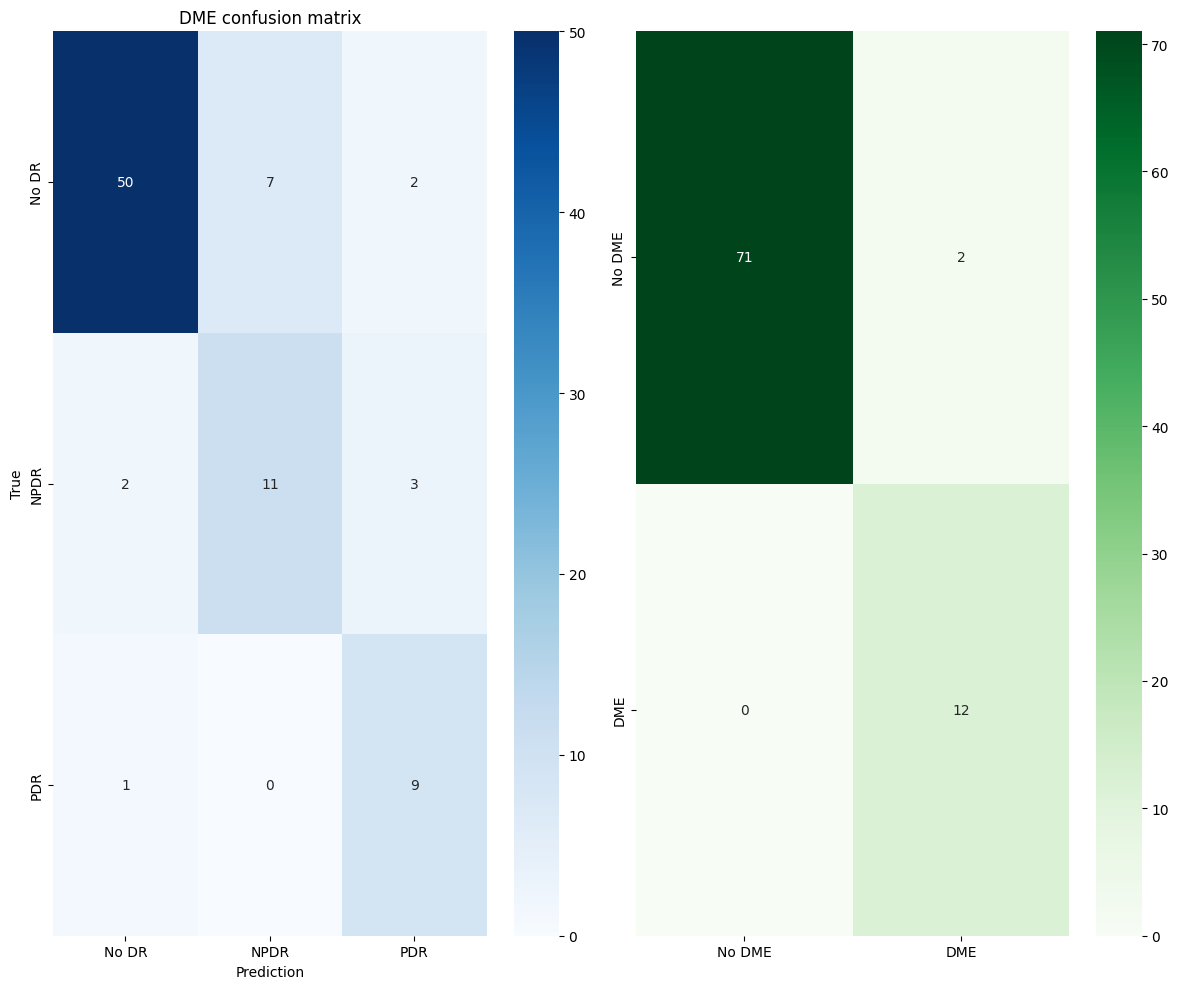

In [ ]:
test_model(
    model=model,
    test_loader=loaders['test_loader'],
    device=device,
    model_path=Config.SAVE_MODEL
)